In [1]:
# importing sys
import sys
# adding src to the system path
sys.path.insert(0, './src')

import os
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from DataSetsLoader import DataSetsLoader
from PointNetFactory import PointNetFactory

C:\Users\binwe\anaconda3\envs\tensorflow26_p39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Global variables
NUM_POINTS = 2048
NUM_CLASSES = 10
NUM_POINT_AXIS = 3
BATCH_SIZE = 32

# Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("GPUs Available: ", physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load Datasets
datasets_loader = DataSetsLoader()
train_points, test_points, train_labels, test_labels, CLASS_MAP = datasets_loader.transform_to_tensorflow_dataset()

processing class: bathtub
processing class: bed
processing class: chair
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [4]:
# Shuffle and Augment Datasets
def augment(points, label):
        # jitter points
        points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
        # shuffle points
        points = tf.random.shuffle(points)
        return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [5]:
point_net_factory = PointNetFactory()

In [6]:
# Build the PointNet model
model = point_net_factory.create_model(NUM_POINTS, NUM_POINT_AXIS, NUM_CLASSES)
# model.summary()

In [7]:
# Train Model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
98/98 [==============================] - 56s 510ms/step - loss: 4.6925 - sparse_categorical_accuracy: 0.3452 - val_loss: 1201367.1250 - val_sparse_categorical_accuracy: 0.1619
Epoch 2/20
98/98 [==============================] - 48s 488ms/step - loss: 3.7692 - sparse_categorical_accuracy: 0.4434 - val_loss: 130489956433920.0000 - val_sparse_categorical_accuracy: 0.3553
Epoch 3/20
98/98 [==============================] - 48s 490ms/step - loss: 3.6241 - sparse_categorical_accuracy: 0.4850 - val_loss: 180635670087737641271296.0000 - val_sparse_categorical_accuracy: 0.3868
Epoch 4/20
98/98 [==============================] - 49s 501ms/step - loss: 3.6910 - sparse_categorical_accuracy: 0.5400 - val_loss: 141561333547008.0000 - val_sparse_categorical_accuracy: 0.5896
Epoch 5/20
98/98 [==============================] - 49s 504ms/step - loss: 3.4664 - sparse_categorical_accuracy: 0.6072 - val_loss: 6678281728.0000 - val_sparse_categorical_accuracy: 0.4041
Epoch 6/20
98/98 [===========

In [8]:
# Save Model
model.save_weights("./model.h5")

# Load Model
new_model = point_net_factory.create_model(NUM_POINTS, NUM_POINT_AXIS, NUM_CLASSES)
new_model.load_weights("./model.h5")

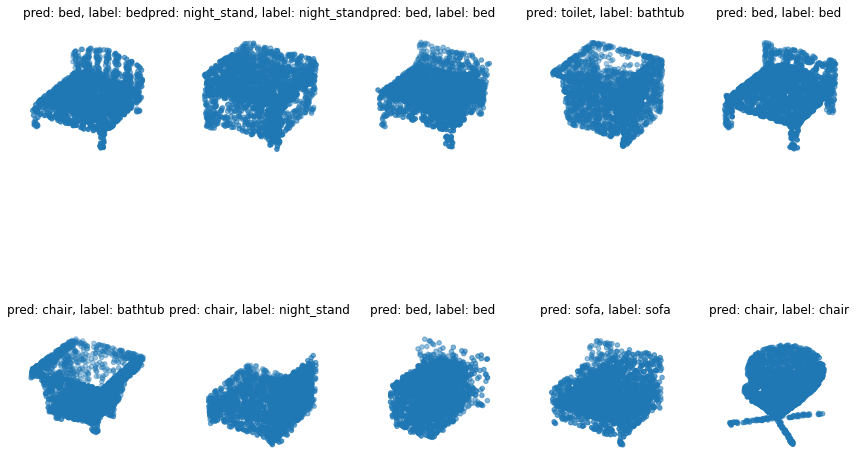

In [9]:
# Predict Results
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:10, ...]
labels = labels[:10, ...]

# run test data through model
preds = new_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()